In [8]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
import statsmodels.api as sm #statistical models (including regression)
import statsmodels.formula.api as smf  #R-like model specification
import matplotlib.pyplot as plt #2-D plotting
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [9]:
# read in Coaches data and create data frame
coaches = pd.read_csv("Coaches9.csv", sep=",",delimiter=None, header="infer")
coaches = coaches.fillna(0)  

# print the first five rows of the data frame
print (pd.DataFrame.head(coaches))

# get a baseline of how many rows in the dataframe
coaches.count(axis=0, level=None, numeric_only=False)


                  School Conference              Coach   SchoolPay  \
0              Air Force   Mt. West       Troy Calhoun   885000.00   
1                  Akron        MAC       Terry Bowden   411000.00   
2                Alabama        SEC         Nick Saban  8307000.00   
3  Alabama at Birmingham      C-USA         Bill Clark   900000.00   
4      Appalachian State   Sun Belt  Scott Satterfield   712500.00   

     TotalPay       Bonus  BonusPaid  AssistantPay       Buyout  
0   885000.00   247000.00         --           0.0           --  
1   412500.00   225000.00   50000.00           0.0    688500.00  
2  8307000.00  1100000.00  500000.00           0.0  33600000.00  
3   900000.00   950000.00  165471.00           0.0   3847500.00  
4   712500.00   295000.00  145000.00           0.0   2160417.00  


School          129
Conference      129
Coach           129
SchoolPay       129
TotalPay        129
Bonus           129
BonusPaid       129
AssistantPay    129
Buyout          129
dtype: int64

In [10]:
# CLEAN DATA

# convert lowercase
coaches = coaches.apply(lambda x: x.astype(str).str.lower())
coaches.columns = coaches.columns.str.lower()

# aggregate numeric columns together
coaches_numeric = [
    'schoolpay',
    'totalpay',
    'bonus',
    'bonuspaid',
    'assistantpay',
    'buyout'
]

# remove non-numeric values and convert to 0
coaches[coaches_numeric] = coaches[coaches_numeric].replace('[\$,--]', '', regex=True)

coaches[coaches_numeric] = coaches[coaches_numeric].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# remove irrelevant columns
coaches = coaches[['school', 'conference','coach', 'schoolpay', 'totalpay', 'bonus', 'bonuspaid']]
                                                              
# check
print (pd.DataFrame.head(coaches))

# summary statatistics
coaches.describe()

                  school conference              coach  schoolpay   totalpay  \
0              air force   mt. west       troy calhoun   885000.0   885000.0   
1                  akron        mac       terry bowden   411000.0   412500.0   
2                alabama        sec         nick saban  8307000.0  8307000.0   
3  alabama at birmingham      c-usa         bill clark   900000.0   900000.0   
4      appalachian state   sun belt  scott satterfield   712500.0   712500.0   

       bonus  bonuspaid  
0   247000.0        0.0  
1   225000.0    50000.0  
2  1100000.0   500000.0  
3   950000.0   165471.0  
4   295000.0   145000.0  


/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/inference.py:244: FutureWarning: Possible set difference at position 4
  re.compile(obj)


,schoolpay,totalpay,bonus,bonuspaid
count,1.290000e+02,1.290000e+02,1.290000e+02,1.290000e+02
mean,2.335563e+06,2.342113e+06,7.250935e+05,1.020011e+05
std,1.898654e+06,1.903114e+06,6.652423e+05,2.088806e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.625700e+05,7.625700e+05,2.200000e+05,0.000000e+00
50%,1.800000e+06,1.830000e+06,6.250000e+05,2.000000e+04
75%,3.550000e+06,3.550000e+06,1.025000e+06,1.000000e+05
max,8.307000e+06,8.307000e+06,3.100000e+06,1.350000e+06


In [11]:
# read in supplementary data 
stadiums = pd.read_csv("stadiums-geocoded.csv", sep=",",delimiter=None, header="infer")
stadiums = stadiums.fillna(0)
grad_rates = pd.read_csv("graduation-rates.csv",sep=",",delimiter=None, header="infer")
grad_rates = grad_rates.fillna(0)
standings = pd.read_csv("2018-season.csv",sep=",",delimiter=None, header="infer")
standings = standings.fillna(0)
donations = pd.read_csv("NCAA_Contributions.csv",sep=",",delimiter=None, header="infer")

print (pd.DataFrame.head(stadiums))
print (pd.DataFrame.head(grad_rates))
print (pd.DataFrame.head(standings))
print (pd.DataFrame.head(donations))


            stadium             city state        team conference  capacity  \
0  Michigan Stadium        Ann Arbor    MI    Michigan    Big Ten    107601   
1    Beaver Stadium  University Park    PA  Penn State    Big Ten    106572   
2      Ohio Stadium         Columbus    OH  Ohio State    Big Ten    104944   
3        Kyle Field  College Station    TX   Texas A&M        SEC    102733   
4   Neyland Stadium        Knoxville    TN   Tennessee        SEC    102455   

   built expanded  div   latitude  longitude  
0   1927     2015  fbs  42.265869 -83.748726  
1   1960     2001  fbs  40.812153 -77.856202  
2   1922     2014  fbs  40.001686 -83.019728  
3   1927     2015  fbs  30.610098 -96.340729  
4   1921     2010  fbs  35.954734 -83.925333  
                  school   gsr   fgr
0              Air Force  93.0   0.0
1                  Akron  58.0  52.0
2                Alabama  73.0  57.0
3  Alabama at Birmingham  60.0  55.0
4      Appalachian State  68.0  56.0
                  Sch

In [12]:
# CLEAN DATA 

# convert lowercase
stadiums = stadiums.apply(lambda x: x.astype(str).str.lower())
stadiums.columns = stadiums.columns.str.lower()

grad_rates = grad_rates.apply(lambda x: x.astype(str).str.lower())
grad_rates.columns = grad_rates.columns.str.lower()

standings = standings.apply(lambda x: x.astype(str).str.lower())
standings.columns = standings.columns.str.lower()

donations = donations.apply(lambda x: x.astype(str).str.lower())
donations.columns = donations.columns.str.lower()

# convert column name: to allow data merge
stadiums = stadiums.rename(columns={'team': 'school'})

# aggregate numeric columns together
stadiums_numeric = ['capacity', 'built', 'expanded']
grad_numeric = ['gsr', 'fgr']
standings_numeric = ['w', 'l', 'pct']

# replace non-numeric values to 0
stadiums[stadiums_numeric] = stadiums[stadiums_numeric].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

grad_rates[grad_numeric] = grad_rates[grad_numeric].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

standings[standings_numeric] = standings[standings_numeric].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

donations['avg_contribution'] = donations['avg_contribution'].apply(
    pd.to_numeric,
    errors='coerce',
).fillna(0)

# get rid of irrelevant columns
stadiums = stadiums[['stadium', 'school','capacity']]
donations = donations [['school','avg_contribution']]
                                                       
                                                              
# check
print (pd.DataFrame.head(stadiums))
print (pd.DataFrame.head(grad_rates))
print (pd.DataFrame.head(standings))
print (pd.DataFrame.head(donations))


            stadium      school  capacity
0  michigan stadium    michigan  107601.0
1    beaver stadium  penn state  106572.0
2      ohio stadium  ohio state  104944.0
3        kyle field   texas a&m  102733.0
4   neyland stadium   tennessee  102455.0
                  school   gsr   fgr
0              air force  93.0   0.0
1                  akron  58.0  52.0
2                alabama  73.0  57.0
3  alabama at birmingham  60.0  55.0
4      appalachian state  68.0  56.0
                  school     w    l    pct
0              air force   5.0  7.0  0.417
1                  akron   4.0  8.0  0.333
2                alabama  14.0  1.0  0.933
3  alabama at birmingham  11.0  3.0  0.786
4      appalachian state  11.0  2.0  0.846
          school  avg_contribution
0        alabama          29065750
1        arizona          18847689
2  arizona state          12195328
3       arkansas          15884411
4         auburn          32323392


In [13]:
stadiums = stadiums.sort_values(by='school').drop_duplicates('school')
stadiums.count (axis=0, level=None, numeric_only=False)

stadium     253
school      253
capacity    253
dtype: int64

In [14]:
grad_rates = grad_rates.sort_values(by='school').drop_duplicates('school')
grad_rates.count(axis=0, level=None, numeric_only=False)

school    130
gsr       130
fgr       130
dtype: int64

In [15]:
standings = standings.sort_values(by='school').drop_duplicates('school')
standings.count(axis=0, level=None, numeric_only=False)

school    130
w         130
l         130
pct       130
dtype: int64

In [16]:
donations = donations.sort_values(by='school').drop_duplicates('school')
donations.count(axis=0, level=None, numeric_only=False)

school              52
avg_contribution    52
dtype: int64

In [17]:
# CLEAN DATA: STADIUMS

# replace acronym with school name
stadiums['school'] = stadiums['school'].replace(['ucf'], 'central florida')
stadiums['school'] = stadiums['school'].replace(['usf'], 'south florida')
stadiums['school'] = stadiums['school'].replace(['utsa'], 'texas-san antonio')
stadiums['school'] = stadiums['school'].replace(['byu'], 'brigham young')
stadiums['school'] = stadiums['school'].replace(['utep'], 'texas-el paso')
stadiums['school'] = stadiums['school'].replace(['tcu'], 'texas christian')
stadiums['school'] = stadiums['school'].replace(['unlv'], 'nevada-las vegas')
stadiums['school'] = stadiums['school'].replace(['smu'], 'southern methodist')
stadiums['school'] = stadiums['school'].replace(['niu'], 'northern illinois')
stadiums['school'] = stadiums['school'].replace(['miami (oh)'], 'miami (ohio)')
stadiums['school'] = stadiums['school'].replace(['fiu'], 'florida international')
stadiums['school'] = stadiums['school'].replace(['umass'], 'massachusetts')


In [18]:
# stadiums summary statistics
stadiums['capacity'].describe()

count       253.000000
mean      33200.466403
std       25904.041476
min        2200.000000
25%       12283.000000
50%       25200.000000
75%       50000.000000
max      107601.000000
Name: capacity, dtype: float64

In [19]:
# donations summary statistics
donations['avg_contribution'].describe()

count    5.200000e+01
mean     1.988869e+07
std      9.043722e+06
min      6.572169e+06
25%      1.257459e+07
50%      1.728337e+07
75%      2.463558e+07
max      4.502486e+07
Name: avg_contribution, dtype: float64

In [43]:
# MERGE DATASETS

# coaches + stadium
merged_df = pd.merge(coaches, stadiums, how='left', left_on='school', right_on='school')

# + graduation rates
merged_df = pd.merge(merged_df, grad_rates, how='left', left_on='school', right_on='school')

# + 2018 standings
merged_df = pd.merge(merged_df, standings, how='left', left_on='school', right_on='school')

# + Avg Contributions starting from 2005
merged_df = pd.merge(merged_df, donations, how='left', left_on='school', right_on='school')

# check
print (pd.DataFrame.head(merged_df))

# make sure none of the rows in coaches data have been deleted
merged_df.count(axis=0, level=None, numeric_only=False) 
# 129 rows for coaches data! Checks out :)


                  school conference              coach  schoolpay   totalpay  \
0              air force   mt. west       troy calhoun   885000.0   885000.0   
1                  akron        mac       terry bowden   411000.0   412500.0   
2                alabama        sec         nick saban  8307000.0  8307000.0   
3  alabama at birmingham      c-usa         bill clark   900000.0   900000.0   
4      appalachian state   sun belt  scott satterfield   712500.0   712500.0   

       bonus  bonuspaid                            stadium  capacity   gsr  \
0   247000.0        0.0                     falcon stadium   46692.0  93.0   
1   225000.0    50000.0  summa field at infocision stadium   30000.0  58.0   
2  1100000.0   500000.0               bryant–denny stadium  101821.0  73.0   
3   950000.0   165471.0                                NaN       NaN  60.0   
4   295000.0   145000.0                kidd brewer stadium   24050.0  68.0   

    fgr     w    l    pct  avg_contribution  
0   

school              129
conference          129
coach               129
schoolpay           129
totalpay            129
bonus               129
bonuspaid           129
stadium             123
capacity            123
gsr                 128
fgr                 128
w                   129
l                   129
pct                 129
avg_contribution     51
dtype: int64

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


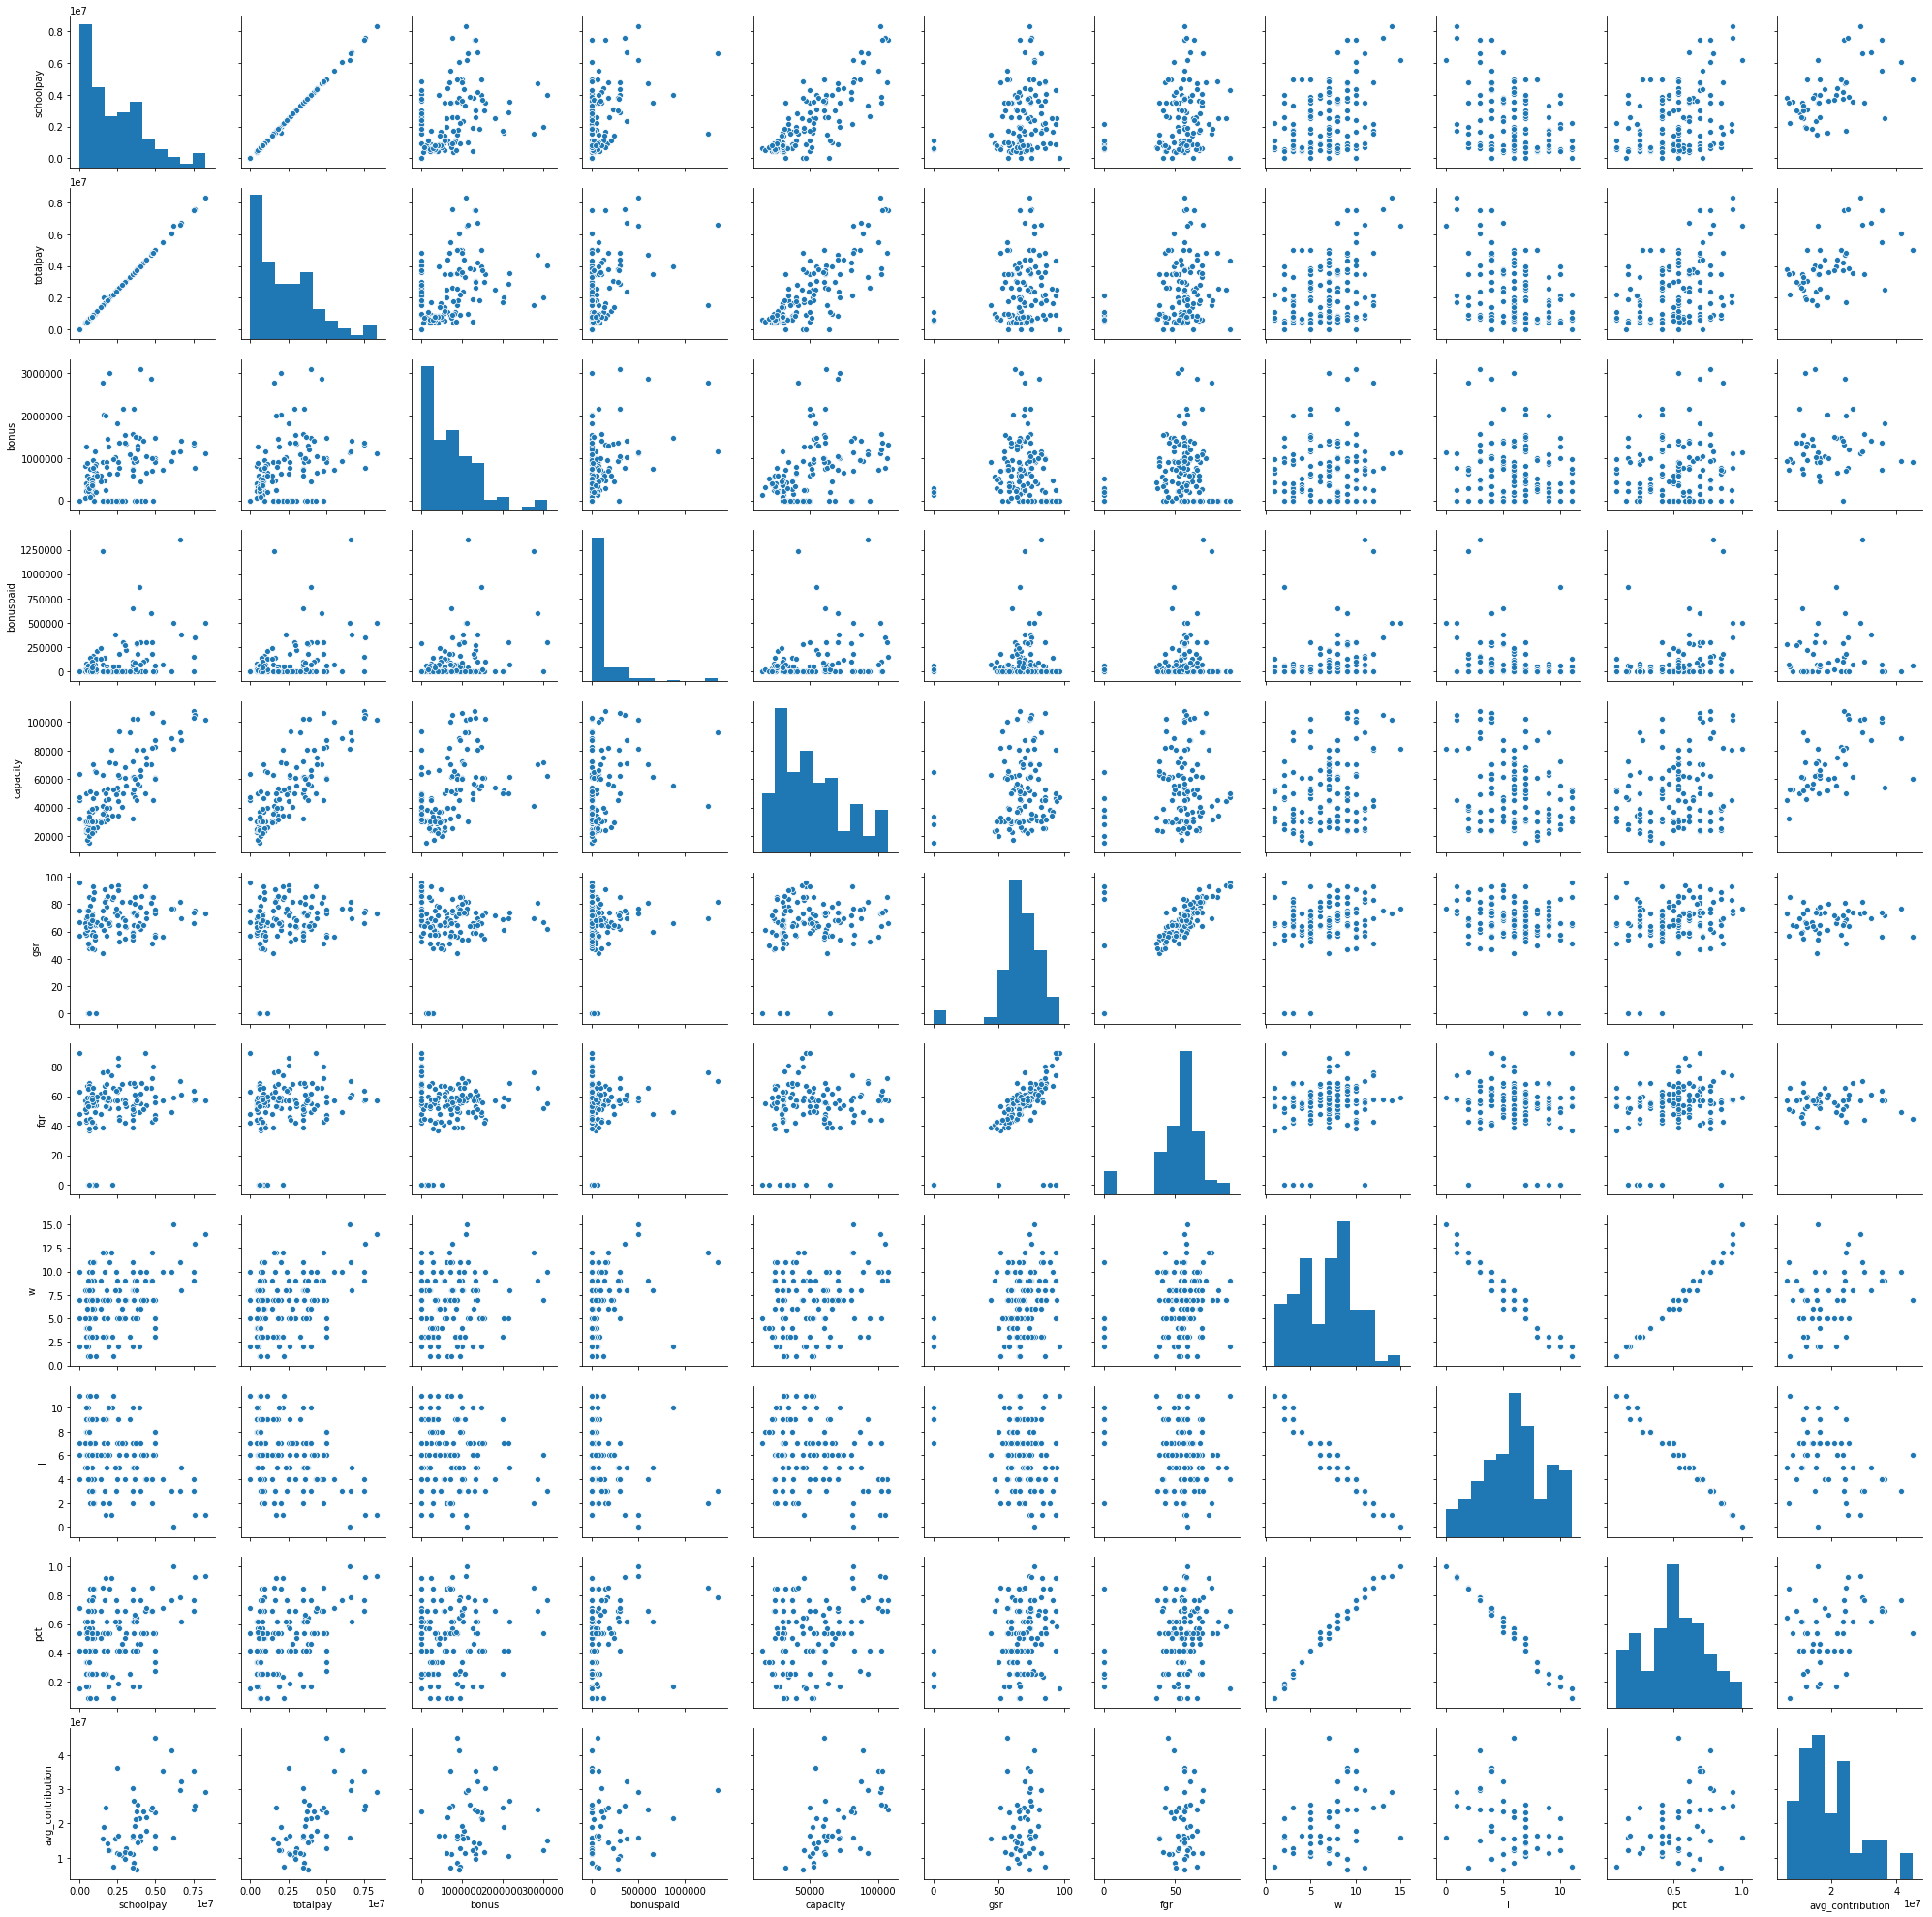

In [15]:
# visualize data
sns.pairplot(merged_df)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


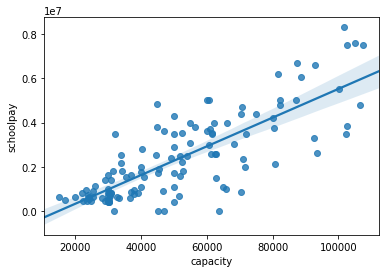

In [21]:
# plot correlation between capacity and school pay
sns.regplot(x='capacity', y='schoolpay', data=merged_df)

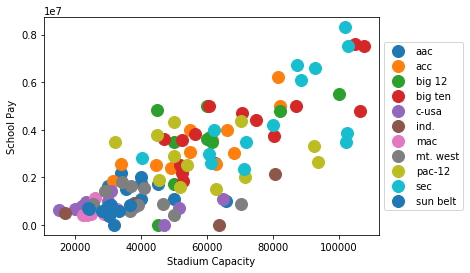

In [22]:
# create scatter plot of salary range  + stadium capacity based on conference. 
groups = merged_df.groupby('conference')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.capacity, group.schoolpay, marker='o', linestyle='', ms=12, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel="Stadium Capacity", ylabel="School Pay")

plt.show()

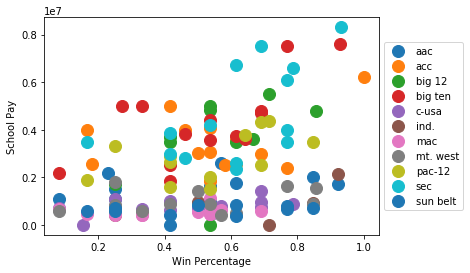

In [23]:
# create scatter plot of salary range + overall win percentage based on conference. 

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.pct, group.schoolpay, marker='o', linestyle='', ms=12, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel="Win Percentage", ylabel="School Pay")

plt.show()

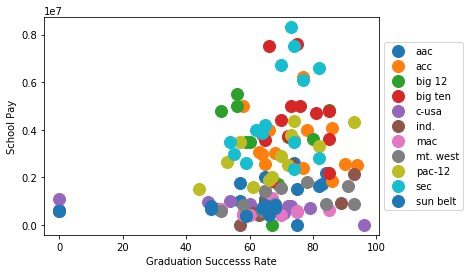

In [24]:
# create scatter plot of salary range + gsr based on conference. 

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.gsr, group.schoolpay, marker='o', linestyle='', ms=12, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel="Graduation Successs Rate", ylabel="School Pay")

plt.show()

In [37]:
# remove outlier gsr data

filtered = merged_df

filtered['gsr']=filtered.gsr.mask(filtered.gsr == 0,filtered['gsr'].mean(skipna=True))

print (pd.DataFrame.head(filtered))

groups = filtered.groupby('conference')

                  school conference              coach  schoolpay   totalpay  \
0              air force   mt. west       troy calhoun   885000.0   885000.0   
1                  akron        mac       terry bowden   411000.0   412500.0   
2                alabama        sec         nick saban  8307000.0  8307000.0   
3  alabama at birmingham      c-usa         bill clark   900000.0   900000.0   
4      appalachian state   sun belt  scott satterfield   712500.0   712500.0   

       bonus  bonuspaid                            stadium  capacity   gsr  \
0   247000.0        0.0                     falcon stadium   46692.0  93.0   
1   225000.0    50000.0  summa field at infocision stadium   30000.0  58.0   
2  1100000.0   500000.0               bryant–denny stadium  101821.0  73.0   
3   950000.0   165471.0                                NaN       NaN  60.0   
4   295000.0   145000.0                kidd brewer stadium   24050.0  68.0   

    fgr     w    l    pct  avg_contribution  
0   

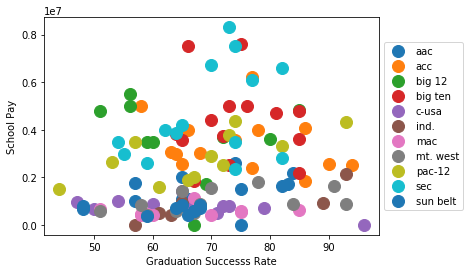

In [38]:
# plot without outliers 

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.gsr, group.schoolpay, marker='o', linestyle='', ms=12, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel="Graduation Successs Rate", ylabel="School Pay")

plt.show()

In [41]:
# CREATE TESTING AND TRAINING DATA
np.random.seed(1234)
merged_df['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(merged_df))
merged_df_train = merged_df[merged_df['runiform'] >= 0.33]
merged_df_test = merged_df[merged_df['runiform'] < 0.33]

# check training data frame
print('\merged_df_train data frame (rows, columns): ',merged_df_train.shape)
print(merged_df_train.head())

# check test data frame
print('\merged_df_test data frame (rows, columns): ',merged_df_test.shape)
print(merged_df_test.head())

\merged_df_train data frame (rows, columns):  (92, 16)
                  school conference              coach  schoolpay   totalpay  \
1                  akron        mac       terry bowden   411000.0   412500.0   
2                alabama        sec         nick saban  8307000.0  8307000.0   
3  alabama at birmingham      c-usa         bill clark   900000.0   900000.0   
4      appalachian state   sun belt  scott satterfield   712500.0   712500.0   
7               arkansas        sec        chad morris  3500000.0  3500000.0   

       bonus  bonuspaid                               stadium  capacity   gsr  \
1   225000.0    50000.0     summa field at infocision stadium   30000.0  58.0   
2  1100000.0   500000.0                  bryant–denny stadium  101821.0  73.0   
3   950000.0   165471.0                                   NaN       NaN  60.0   
4   295000.0   145000.0                   kidd brewer stadium   24050.0  68.0   
7  1000000.0        0.0  donald w. reynolds razorback stadi

In [17]:
# create initial model
model_1 = str('schoolpay ~ pct + gsr + fgr')

# fit the model to the training set
train_model_fit = smf.ols(model_1, data = merged_df_train, missing='drop').fit()
# summary of model fit to the training set
print(train_model_fit.summary())


                            OLS Regression Results                            
Dep. Variable:              schoolpay   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     5.575
Date:                Sat, 02 Feb 2019   Prob (F-statistic):            0.00152
Time:                        03:11:59   Log-Likelihood:                -1438.4
No. Observations:                  91   AIC:                             2885.
Df Residuals:                      87   BIC:                             2895.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.793e+04    8.4e+05     -0.105      0.9

In [18]:
## first model had terrible R-square. try again.
# create initial model
model_1 = str('schoolpay ~ capacity + pct')

# fit the model to the training set
train_model_fit = smf.ols(model_1, data = merged_df_train, missing='drop').fit()
# summary of model fit to the training set
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              schoolpay   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     94.96
Date:                Sat, 02 Feb 2019   Prob (F-statistic):           2.16e-22
Time:                        03:12:03   Log-Likelihood:                -1347.7
No. Observations:                  88   AIC:                             2701.
Df Residuals:                      85   BIC:                             2709.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.579e+06   3.44e+05     -4.584      0.0

In [19]:
# second model is a significant improvement.
# attempt a third model for better results

model_1 = str('schoolpay ~ capacity + avg_contribution')

# fit the model to the training set
train_model_fit = smf.ols(model_1, data = merged_df_train, missing='drop').fit()
# summary of model fit to the training set
print(train_model_fit.summary())


                            OLS Regression Results                            
Dep. Variable:              schoolpay   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     20.90
Date:                Sat, 02 Feb 2019   Prob (F-statistic):           1.20e-06
Time:                        03:12:06   Log-Likelihood:                -566.89
No. Observations:                  37   AIC:                             1140.
Df Residuals:                      34   BIC:                             1145.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -2.554e+05   7.06e+05  

In [20]:
# avg_contribution seems to have brought the model down quite a bit. 
# likely due to the fact that the pool of schools with donation.

model_1 = str('schoolpay ~ capacity + conference')

# fit the model to the training set
train_model_fit = smf.ols(model_1, data = merged_df_train, missing='drop').fit()
# summary of model fit to the training set
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              schoolpay   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     22.76
Date:                Sat, 02 Feb 2019   Prob (F-statistic):           9.43e-20
Time:                        03:12:12   Log-Likelihood:                -1335.2
No. Observations:                  88   AIC:                             2694.
Df Residuals:                      76   BIC:                             2724.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -8.07

In [21]:
# last attempt to improve R squared

model_1 = str('schoolpay ~ capacity + conference + pct')

# fit the model to the training set
train_model_fit = smf.ols(model_1, data = merged_df_train, missing='drop').fit()
# summary of model fit to the training set
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              schoolpay   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     24.30
Date:                Sat, 02 Feb 2019   Prob (F-statistic):           4.28e-21
Time:                        03:12:15   Log-Likelihood:                -1329.5
No. Observations:                  88   AIC:                             2685.
Df Residuals:                      75   BIC:                             2717.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.20

In [57]:
# predict
target = merged_df[merged_df['school'] == 'syracuse']
train_model_fit.predict(target[['capacity', 'conference', 'pct']])

102    3.409961e+06
dtype: float64

In [60]:
# create mixed linear model grouped by conference

# create a new model 
model_2 = str('schoolpay ~ capacity + pct')

train_model_fit2 = smf.mixedlm(model_2, merged_df_train, groups=merged_df_train['conference'], missing='drop').fit()

print(train_model_fit2.summary())


                   Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     schoolpay        
No. Observations:     92          Method:                 REML             
No. Groups:           11          Scale:                  918347973340.5237
Min. group size:      4           Likelihood:             -1376.2371       
Max. group size:      12          Converged:              Yes              
Mean group size:      8.4                                                  
---------------------------------------------------------------------------
               Coef.        Std.Err.    z    P>|z|    [0.025       0.975]  
---------------------------------------------------------------------------
Intercept      -880186.760 454194.954 -1.938 0.053 -1770392.511   10018.992
capacity            45.891      7.144  6.423 0.000       31.888      59.894
pct            1395981.251 471529.062  2.961 0.003   471801.272 2320161.230
Group Var 604280083095.954 4127

In [61]:
train_model_fit2.predict(target[['capacity', 'conference', 'pct']])

102    2.453455e+06
dtype: float64

In [40]:
# big 10 investigation
big10_df = merged_df

# change syracuse conference to big ten 
big10_df['conference'][(big10_df['school'] == 'syracuse')] = 'big ten'

#check
big10_df.loc[(big10_df['school'] == 'syracuse')]

#print (pd.DataFrame.head(big10_df))
#print (big10_df.shape)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,school,conference,coach,schoolpay,totalpay,bonus,bonuspaid,stadium,capacity,gsr,fgr,w,l,pct,avg_contribution
102,syracuse,big ten,dino babers,2401206.0,2401206.0,0.0,0.0,carrier dome,49250.0,77.0,64.0,10.0,3.0,0.769,NaN


In [98]:
big10_target = big10_df[big10_df['school'] == 'syracuse']

# mixed linear effects model prediction
train_model_fit2.predict(big10_target[['capacity', 'conference', 'pct']])

102    2.453455e+06
dtype: float64

In [100]:
# linear regression
train_model_fit.predict(big10_target[['capacity', 'conference', 'pct']])

102    3.546605e+06
dtype: float64

In [50]:
big10_df.loc[(big10_df['school'] == 'syracuse')]

,school,conference,coach,schoolpay,totalpay,bonus,bonuspaid,stadium,capacity,gsr,fgr,w,l,pct,avg_contribution
102,syracuse,big ten,dino babers,2401206.0,2401206.0,0.0,0.0,carrier dome,49250.0,77.0,64.0,10.0,3.0,0.769,NaN


In [48]:
big10_df[(big10_df['conference'] == 'big ten')].describe()

,schoolpay,totalpay,bonus,bonuspaid,capacity,gsr,fgr,w,l,pct,avg_contribution
count,1.500000e+01,1.500000e+01,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,1.200000e+01
mean,4.177160e+06,4.177160e+06,9.194445e+05,139666.666667,70353.933333,74.266667,60.266667,7.066667,5.666667,0.544667,1.700710e+07
std,1.715859e+06,1.715859e+06,7.136893e+05,177184.998828,22127.837973,7.274875,5.861090,3.127451,2.497618,0.220009,6.502862e+06
min,1.830000e+06,1.830000e+06,0.000000e+00,0.000000,47130.000000,64.000000,50.000000,1.000000,1.000000,0.083000,7.451606e+06
25%,3.031000e+06,3.031000e+06,6.375000e+05,0.000000,52489.500000,68.500000,57.000000,5.000000,4.000000,0.417000,1.248272e+07
50%,3.800000e+06,3.800000e+06,9.500000e+05,50000.000000,60670.000000,73.000000,58.000000,7.000000,6.000000,0.538000,1.548437e+07
75%,4.900000e+06,4.900000e+06,1.145000e+06,235000.000000,83706.000000,79.000000,65.000000,9.000000,7.000000,0.692000,2.372238e+07
max,7.600000e+06,7.600000e+06,2.875000e+06,600000.000000,107601.000000,85.000000,72.000000,13.000000,11.000000,0.929000,2.526268e+07


In [44]:
merged_df.loc[(merged_df['school'] == 'syracuse')]

,school,conference,coach,schoolpay,totalpay,bonus,bonuspaid,stadium,capacity,gsr,fgr,w,l,pct,avg_contribution
102,syracuse,acc,dino babers,2401206.0,2401206.0,0.0,0.0,carrier dome,49250.0,77.0,64.0,10.0,3.0,0.769,NaN


In [49]:
merged_df[(merged_df['conference'] == 'acc')].describe()

,schoolpay,totalpay,bonus,bonuspaid,capacity,gsr,fgr,w,l,pct,avg_contribution
count,1.400000e+01,1.400000e+01,1.400000e+01,14.000000,12.000000,14.000000,14.000000,14.000000,14.000000,14.000000,8.000000e+00
mean,3.409629e+06,3.433797e+06,7.323512e+05,147851.214286,57675.333333,74.714286,62.857143,7.142857,5.714286,0.544000,1.783211e+07
std,1.165548e+06,1.229711e+06,7.534458e+05,254303.852926,16271.463500,11.193601,12.126621,3.207135,2.462912,0.213062,5.632102e+06
min,1.831580e+06,1.831580e+06,0.000000e+00,0.000000,31500.000000,58.000000,47.000000,2.000000,0.000000,0.167000,9.605338e+06
25%,2.549446e+06,2.549446e+06,0.000000e+00,0.000000,48062.500000,65.250000,53.500000,6.250000,5.000000,0.471500,1.513880e+07
50%,3.038868e+06,3.038868e+06,6.675000e+05,25000.000000,58250.000000,75.500000,60.500000,7.000000,6.000000,0.538000,1.649964e+07
75%,3.995108e+06,3.995108e+06,1.345000e+06,187500.000000,66774.750000,84.000000,69.000000,8.000000,7.000000,0.615000,2.197844e+07
max,6.205000e+06,6.543350e+06,2.165000e+06,869917.000000,82300.000000,94.000000,86.000000,15.000000,10.000000,1.000000,2.664437e+07
